In [209]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Load the processed dataset
df = pd.read_csv('Dataset/train_processed.csv')
test_df = pd.read_csv('Dataset/test_processed.csv')

bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)
bool_cols_test = test_df.select_dtypes(include='bool').columns
test_df[bool_cols_test] = test_df[bool_cols_test].astype(int)

In [210]:
# Compute pair frequency (A → B)
account_pairs = df.groupby(['From Account', 'To Account']).size().reset_index(name='pair_frequency')

# Compute reverse pair frequency (B → A)
reverse_pairs = account_pairs.copy()
reverse_pairs.columns = ['To Account', 'From Account', 'reverse_pair_frequency']  # flip column names

# Merge both into the original dataframe
df = df.merge(account_pairs, on=['From Account', 'To Account'], how='left')
df = df.merge(reverse_pairs, on=['From Account', 'To Account'], how='left')  # correct merge

# Fill missing frequencies
df['pair_frequency'].fillna(1, inplace=True)
df['reverse_pair_frequency'].fillna(0, inplace=True)

# Flag circular transactions
df['is_circular'] = (df['reverse_pair_frequency'] > 0).astype(int)

C:\Users\emanu\AppData\Local\Temp\ipykernel_23904\1452891232.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pair_frequency'].fillna(1, inplace=True)
C:\Users\emanu\AppData\Local\Temp\ipykernel_23904\1452891232.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [211]:
# Compute pair frequency (A → B)
account_pairs = test_df.groupby(['From Account', 'To Account']).size().reset_index(name='pair_frequency')

# Compute reverse pair frequency (B → A)
reverse_pairs = account_pairs.copy()
reverse_pairs.columns = ['To Account', 'From Account', 'reverse_pair_frequency']  # flip column names

# Merge both into the original dataframe
test_df = test_df.merge(account_pairs, on=['From Account', 'To Account'], how='left')
test_df = test_df.merge(reverse_pairs, on=['From Account', 'To Account'], how='left')  # correct merge

# Fill missing frequencies
test_df['pair_frequency'].fillna(1, inplace=True)
test_df['reverse_pair_frequency'].fillna(0, inplace=True)

# Flag circular transactions
test_df['is_circular'] = (test_df['reverse_pair_frequency'] > 0).astype(int)

C:\Users\emanu\AppData\Local\Temp\ipykernel_23904\3936049671.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['pair_frequency'].fillna(1, inplace=True)
C:\Users\emanu\AppData\Local\Temp\ipykernel_23904\3936049671.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [212]:
import  networkx as nx
# Initialize a directed graph
G = nx.DiGraph()

# Add edges with attributes
for idx, row in df.iterrows():
    G.add_edge(
        row['From Account'],
        row['To Account'],
        amount_log=row['Amount Paid_log'],
        pair_frequency=row['pair_frequency'],
        reverse_pair_frequency=row['reverse_pair_frequency'],
        is_circular=row['is_circular']
    )


In [213]:
import  networkx as nx
# Initialize a directed graph
G_test = nx.DiGraph()

# Add edges with attributes
for idx, row in test_df.iterrows():
    G_test.add_edge(
        row['From Account'],
        row['To Account'],
        amount_log=row['Amount Paid_log'],
        pair_frequency=row['pair_frequency'],
        reverse_pair_frequency=row['reverse_pair_frequency'],
        is_circular=row['is_circular']
    )

In [214]:
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, k=min(1000, len(G.nodes())))

In [215]:
in_degree_centrality_test = nx.in_degree_centrality(G_test)
out_degree_centrality_test = nx.out_degree_centrality(G_test)
betweenness_centrality_test = nx.betweenness_centrality(G_test, k=min(1000, len(G_test.nodes())))

In [216]:
#df['from_out_degree_centrality'] = df['From Account'].map(out_degree_centrality).fillna(0)
df['from_betweenness_centrality'] = df['From Account'].map(betweenness_centrality).fillna(0)
#df['to_in_degree_centrality'] = df['To Account'].map(in_degree_centrality).fillna(0)
df['to_betweenness_centrality'] = df['To Account'].map(betweenness_centrality).fillna(0)

In [217]:
#test_df['from_out_degree_centrality'] = test_df['From Account'].map(out_degree_centrality_test).fillna(0)
test_df['from_betweenness_centrality'] = test_df['From Account'].map(betweenness_centrality_test).fillna(0)
#test_df['to_in_degree_centrality'] = test_df['To Account'].map(in_degree_centrality_test).fillna(0)
test_df['to_betweenness_centrality'] = test_df['To Account'].map(betweenness_centrality_test).fillna(0)

In [218]:
df = df.drop(columns=['From Account', 'To Account'], errors='ignore')


# Separate features and target
X = df.drop(columns=['Is Laundering'])
y = df['Is Laundering']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [219]:
#!pip install optuna

In [220]:
test_df = test_df.drop(columns=['From Account', 'To Account'], errors='ignore')

In [221]:
from sklearn.metrics import roc_auc_score, confusion_matrix

def calculate_balanced_accuracy(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    return (tpr + tnr) / 2

def calculate_fraud_capture_rate(y_true, y_prob, N=485):
    sorted_indices = np.argsort(y_prob)[::-1]
    top_N_indices = sorted_indices[:N]
    frauds_in_top_N = np.sum(y_true.iloc[top_N_indices] if hasattr(y_true, 'iloc') else y_true[top_N_indices])
    total_frauds = np.sum(y_true)
    return frauds_in_top_N / total_frauds if total_frauds > 0 else 0

def calculate_composite_score(y_true, y_pred, y_prob, N=485):
    auc_score = roc_auc_score(y_true, y_prob)
    balanced_acc = calculate_balanced_accuracy(y_true, y_pred)
    fraud_capture = calculate_fraud_capture_rate(y_true, y_prob, N)
    return (auc_score + balanced_acc + fraud_capture) / 3


### LGBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
import numpy as np

def objective(trial):
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    
    # 🔧 Threshold being tuned by Optuna
    threshold = trial.suggest_float("threshold", 0.05, 0.5)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 5),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'scale_pos_weight': scale_pos_weight,
        'force_col_wise': True,
        'verbosity': -1
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    auc_scores = [] 
    balanced_accuracies = []
    fraud_capture_rates = []
    scores = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = lgb.Classifier(**params)
        model.fit(X_fold_train, y_fold_train)

        y_prob = model.predict_proba(X_fold_val)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        auc_score = roc_auc_score(y_fold_val, y_prob)
        balanced_acc = calculate_balanced_accuracy(y_fold_val, y_pred)
        fraud_capture = calculate_fraud_capture_rate(y_fold_val, y_prob, N=485)
        score = calculate_composite_score(y_fold_val, y_pred, y_prob, N=485)

        auc_scores.append(auc_score)
        balanced_accuracies.append(balanced_acc)    
        fraud_capture_rates.append(fraud_capture)
        scores.append(score)

    print(f"AUC: {np.mean(auc_scores)}, Balanced Accuracy: {np.mean(balanced_accuracies)}, Fraud Capture Rate: {np.mean(fraud_capture_rates)}, Composite Score: {np.mean(scores)}")

    return np.mean(scores)


SyntaxError: invalid syntax (447897438.py, line 40)

In [223]:
import optuna

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

print("Best Hyperparameters:", study.best_params)
print("Best Composite Score:", round(study.best_value, 4))


[I 2025-06-16 04:36:33,046] A new study created in memory with name: no-name-59feb65f-e906-4196-b6a2-3066926806a6
C:\Users\emanu\AppData\Local\Temp\ipykernel_23904\3679706343.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
[I 2025-06-16 04:36:34,678] Trial 0 finished with value: 0.997078840825987 and parameters: {'threshold': 0.21854305348131314, 'n_estimators': 291, 'learning_rate': 0.0483437145318464, 'max_depth': 11, 'num_leaves': 23, 'min_child_samples': 16, 'subsample': 0.7174250836504598, 'subsample_freq': 5, 'colsample_bytree': 0.8404460046972835, 'reg_alpha': 0.7080725777960455, 'reg_lambda': 0.020584494295802447, 'max_bin': 297}. Best is trial 0 with value: 0.997078840825987.
C:\Users\emanu\AppData\Local\Temp\ipykernel_23904\3679706343.py:14: 

Best Hyperparameters: {'threshold': 0.17200370976154836, 'n_estimators': 298, 'learning_rate': 0.15842905458222684, 'max_depth': 9, 'num_leaves': 32, 'min_child_samples': 16, 'subsample': 0.7289060968754346, 'subsample_freq': 3, 'colsample_bytree': 0.8821882602239886, 'reg_alpha': 0.1561526501888254, 'reg_lambda': 0.3799395122065382, 'max_bin': 280}
Best Composite Score: 0.9976


In [224]:
import lightgbm as lgb
import pandas as pd
import numpy as np

# Updated best hyperparameters and threshold
best_params_lgb = {
    'n_estimators': 206,
    'learning_rate': 0.19303856981074463,
    'max_depth': 10,
    'num_leaves': 36,
    'min_child_samples': 18,
    'subsample': 0.7243672924502814,
    'subsample_freq': 5,
    'colsample_bytree': 0.9975198203040716,
    'reg_alpha': 0.24386923304442928,
    'reg_lambda': 0.5484669166472226,
    'max_bin': 295,
    'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    'force_col_wise': True,
    'verbosity': -1
}

# Train final model
final_lgb = lgb.LGBMClassifier(**best_params_lgb)
final_lgb.fit(X_train, y_train)

# Predict probabilities
test_probs_lgb = final_lgb.predict_proba(test_df)[:, 1]

# Use best threshold for classification
best_threshold = 0.2139582880040267
test_preds = (test_probs_lgb >= best_threshold).astype(int)

# Save predictions to submission file
submission = pd.DataFrame({
    0: test_probs_lgb,
    1: test_preds
})
submission.to_csv("submission.txt", sep=" ", header=False, index=False)

In [225]:
with open("submission_lightgbm.txt", "w") as f:
    for prob, pred in zip(test_probs_lgb, test_preds):
        f.write(f"{prob} {pred}\n")


### XGB

In [ ]:
import xgboost as xgb

def objective(trial):
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    
    # Tune threshold as part of objective
    threshold = trial.suggest_float("threshold", 0.05, 0.5)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'verbosity': 0
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    auc_scores = [] 
    balanced_accuracies = []
    fraud_capture_rates = []
    scores = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_fold_train, y_fold_train)

        y_prob = model.predict_proba(X_fold_val)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        auc_score = roc_auc_score(y_fold_val, y_prob)
        balanced_acc = calculate_balanced_accuracy(y_fold_val, y_pred)
        fraud_capture = calculate_fraud_capture_rate(y_fold_val, y_prob, N=485)
        score = calculate_composite_score(y_fold_val, y_pred, y_prob, N=485)

        auc_scores.append(auc_score)
        balanced_accuracies.append(balanced_acc)    
        fraud_capture_rates.append(fraud_capture)
        scores.append(score)

    print(f"AUC: {np.mean(auc_scores)}, Balanced Accuracy: {np.mean(balanced_accuracies)}, Fraud Capture Rate: {np.mean(fraud_capture_rates)}, Composite Score: {np.mean(scores)}")

    return np.mean(scores)


In [227]:
import optuna

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

print("✅ Best XGBoost Parameters:", study.best_params)
print("🎯 Best Composite Score:", round(study.best_value, 4))


[I 2025-06-16 04:37:49,424] A new study created in memory with name: no-name-0304bfa1-33db-4425-ba5b-4d41c55aadac
C:\Users\emanu\AppData\Local\Temp\ipykernel_23904\1909391582.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
[I 2025-06-16 04:37:52,087] Trial 0 finished with value: 0.9972811542537358 and parameters: {'threshold': 0.21854305348131314, 'n_estimators': 291, 'learning_rate': 0.0483437145318464, 'max_depth': 11, 'min_child_weight': 2, 'gamma': 0.7799726016810132, 'subsample': 0.6232334448672797, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.6011150117432088, 'reg_lambda': 0.7080725777960455}. Best is trial 0 with value: 0.9972811542537358.
C:\Users\emanu\AppData\Local\Temp\ipykernel_23904\1909391582.py:11: FutureWarning: suggest_logun

✅ Best XGBoost Parameters: {'threshold': 0.3595320880199634, 'n_estimators': 286, 'learning_rate': 0.03441730150512816, 'max_depth': 12, 'min_child_weight': 4, 'gamma': 0.06655413271247834, 'subsample': 0.6364784353029371, 'colsample_bytree': 0.960836926077814, 'reg_alpha': 0.8384948295032638, 'reg_lambda': 0.629887207892041}
🎯 Best Composite Score: 0.9975


In [228]:
import xgboost as xgb
import pandas as pd
import numpy as np

# Updated best XGBoost hyperparameters
best_params_xgb = {
    'n_estimators': 218,
    'learning_rate': 0.009292098791989615,
    'max_depth': 10,
    'min_child_weight': 5,
    'gamma': 1.91571470173852,
    'subsample': 0.6024546562191404,
    'colsample_bytree': 0.6631805200240224,
    'reg_alpha': 0.8187568380821291,
    'reg_lambda': 0.2900888686288967,
    'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'verbosity': 0
}

# Train final model
final_xgb = xgb.XGBClassifier(**best_params_xgb)
final_xgb.fit(X_train, y_train)

# Predict probabilities on test set
test_probs_xgb = final_xgb.predict_proba(test_df)[:, 1]

# Apply tuned threshold
best_threshold = 0.2628563253896626
test_preds = (test_probs_xgb >= best_threshold).astype(int)

# Create submission file
submission = pd.DataFrame({
    0: test_probs_xgb,
    1: test_preds
})
submission.to_csv("submission.txt", sep=" ", header=False, index=False)



In [229]:
with open("submission_xgb.txt", "w") as f:
    for prob, pred in zip(test_probs_xgb, test_preds):
        f.write(f"{prob} {pred}\n")


In [230]:
# Simple average ensemble
blended_probs = 0.4 * test_probs_lgb + 0.6 * test_probs_xgb

In [231]:
with open("submission_ens.txt", "w") as f:
    for prob, pred in zip(blended_probs, test_preds):
        f.write(f"{prob} {pred}\n")


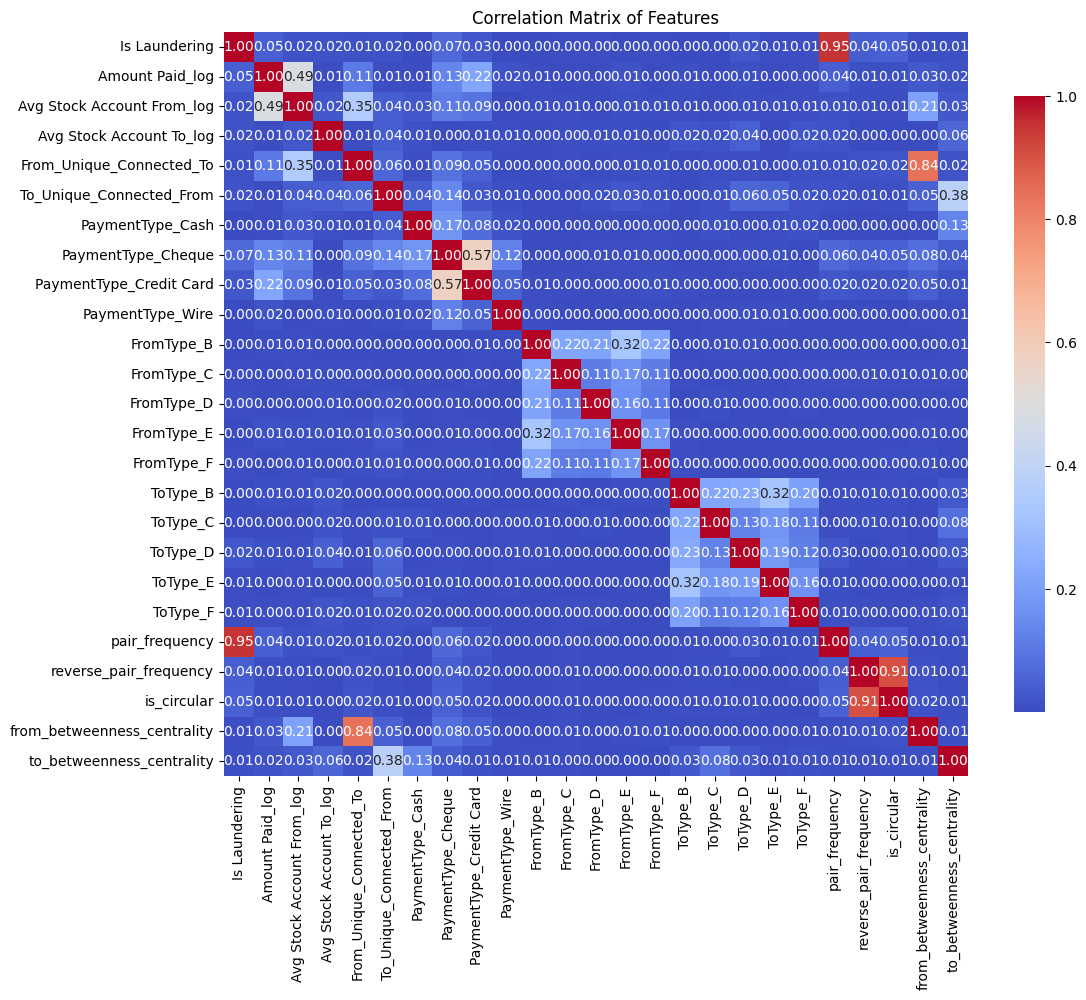

In [232]:
# cor matrix df
cor_matrix = df.corr().abs()
# plot
import matplotlib.pyplot as plt
import seaborn as sns   
plt.figure(figsize=(12, 10))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
# Show the plot
plt.title('Correlation Matrix of Features')
plt.show()
